# Udacity - Data Engineering Capstone Project

## Project summary

In this project, it is assumed that we are working in the data engineering department in Yelp, and we need to provide data to BI analysts to create dashboards and answer the business questions i.e how's the performance of yelp from time to time.

Typical business questions are: 
- What is the user growth from time to time?
- How many checkins/reviews are given from users from time to time?
- What are the most popular restaurant from time to time?

With these information, business department can react based on the results such as more advertisements, provide incentives etc.

## Data sources

Most of the source files are from the YELP dataset, which is available here: https://www.yelp.com/dataset
        
In this project, the following files from the dataset are used: 
- business.json -- Contains business data including location data, attributes, and categories
- review.json -- Contains full review text data including the user_id that wrote the review and the business_id the review is written for
- user.json -- User data including the user's friend mapping and all the metadata associated with the user.
- checkin.json -- Checkins on a business.
- tip.json -- Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions

And to extend the information of location, we also use the csv file here: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/ 

In this case, we have 2 different forms of data source. 

## Project steps

The project follows the follow steps:

- Step 1: Scope the Project and Gather Data
- Step 2: Explore and Assess the Data
- Step 3: Define the Data Model
- Step 4: Run ETL to Model the Data
- Step 5: Complete Project Write Up

## Step 1: Scope the Project and Gather Data

In this project, there will be 2 main parts: The data cleaning before loading to S3, and the ETL process from loading the data from S3 to redshift

The first part is to demonstrate the whole process of cleaning the data in this notebook. From the data in the source file, it is very large and contains a lot of information that we do not need e.g text data. Meanwhile, the data covers the period since 2011, which is not necessary to achieve the goal mentioned above because the business environment has been cheanged in the past 10 years. 
Finally, the output after the cleansing will be uploaded to S3. 

The second part is the ETL process. In this part, we will use the data from S3, that we have cleaned before, to load the data into redshift, and define the business model. This part will be done in airflow. 

To start with, let's load the package that we need and initate spark sessions

In [1]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd

In [2]:
# Initiate the spark session
spark = SparkSession.builder.appName('abc').getOrCreate()

We can read through all the source data one by one, to see the columns that contain inside. 

Meanwhile, to better visualize the data, we can extract part of the data from spark to pandas

### Exploring business data

In [3]:
business_data = spark.read.json('D:\yelp_dataset\yelp_academic_dataset_business.json')
business_data.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [4]:
# Add in id column so that we can make sample from the data and display in pandas
business_data = business_data.withColumn("id", monotonically_increasing_id())

In [5]:
sample_pyspark_business_df = business_data.filter(col("id").between(1,100))
sample_pandas_business_df = sample_pyspark_business_df.toPandas()
sample_pandas_business_df

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,id
0,7000 NE Airport Way,"(None, None, u'beer_and_wine', {'romantic': Fa...",tCbdrRPZA0oiIYSmHG3J0w,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Portland,"(5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-18:0, 5:0-1...",1,45.588906,-122.593331,Flying Elephants at PDX,97218,126,4.0,OR,1
1,4720 Hawthorne Ave,"(None, None, None, None, None, None, None, Fal...",bvN78flM8NLprQ1a1y5dRg,"Antiques, Fashion, Used, Vintage & Consignment...",Portland,"(11:0-18:0, None, 11:0-18:0, 11:0-18:0, 11:0-1...",1,45.511907,-122.613693,The Reclaimory,97214,13,4.5,OR,2
2,2566 Enterprise Rd,"(None, None, None, None, None, None, None, Non...",oaepsyvc0J17qwi8cfrOWg,"Beauty & Spas, Hair Salons",Orange City,None,1,28.914482,-81.295979,Great Clips,32763,8,3.0,FL,3
3,1046 Memorial Dr SE,"(None, None, None, None, None, None, None, Non...",PE9uqAjdw0E4-8mjGl3wVA,"Gyms, Active Life, Interval Training Gyms, Fit...",Atlanta,"(16:0-19:0, 16:0-19:0, 9:0-11:0, None, 16:0-19...",1,33.747027,-84.353424,Crossfit Terminus,30316,14,4.0,GA,4
4,3755 Main St,"(None, None, u'none', {'romantic': False, 'int...",D4JtQNTI4X3KcbzacDJsMw,"Restaurants, Thai",Vancouver,"(17:0-21:0, 17:0-21:0, 17:0-21:0, 17:0-21:0, 1...",1,49.251342,-123.101333,Bob Likes Thai Food,V5V,169,3.5,BC,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1206 River St,"(None, None, None, None, None, None, None, Tru...",xlKLfEm9j1q6wWhO26iH6g,"Home & Garden, Paint Stores, Hardware Stores, ...",Hyde Park,"(7:30-17:30, 7:30-17:30, 8:0-17:0, None, 7:30-...",1,42.255957,-71.121394,Central Paint & True Value,02136,10,5.0,MA,96
96,108 N Main St,"(None, None, u'none', {'romantic': False, 'int...",gmLYiyg_hW_DVQWEPgfRQA,"Restaurants, American (New), Bistros",Buda,"(17:0-21:0, None, 17:0-21:0, None, 17:0-21:0, ...",0,30.081542,-97.844353,Viuda Bistro,78610,21,4.5,TX,97
97,294 Massachusetts Ave,"(None, None, None, None, None, None, None, Tru...",FkS4OmTBeNHPK3sV4PBcIw,"Active Life, Sporting Goods, Fashion, Shoe Sto...",Cambridge,"(11:0-19:0, 11:0-20:0, 10:0-18:0, 11:0-17:0, 1...",1,42.362186,-71.098656,Heartbreak Hill Running Company,02139,12,4.5,MA,98
98,564 West Broadway,"(None, None, None, None, None, None, None, Tru...",mBE0BkG-zTm-WCUVChIRCA,"Yoga, Fitness & Instruction, Active Life, Pilates",Vancouver,"(9:30-20:30, 9:30-20:30, 9:30-20:30, 9:30-20:3...",1,49.263118,-123.117020,Oxygen Yoga & Fitness,V5Z 1E6,5,4.0,BC,99


In [6]:
business_data.dtypes

[('address', 'string'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>'),
 ('business_id', 'string'),
 ('categories', 'string'),
 ('city', 'string'),
 ('hours',
  'struct<Friday:st

### Exploring review data

In [7]:
review_data = spark.read.json('D:\yelp_dataset\yelp_academic_dataset_review.json')
review_data.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [8]:
# Add in id column so that we can make sample from the data and display in pandas
review_data = review_data.withColumn("id", monotonically_increasing_id())

In [9]:
sample_pyspark_review_df = review_data.filter(col("id").between(1,100))
sample_pandas_review_df = sample_pyspark_review_df.toPandas()
sample_pandas_review_df

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,id
0,RA4V8pr014UyUbDvI-LW2A,0,2015-07-03 20:38:25,0,8bFej1QE5LXp4O05qjGqXA,4.0,This store is pretty good. Not as great as Wal...,1,YoVfDbnISlW0f7abNQACIg,1
1,_sS2LBIGNT5NQb6PD1Vtjw,0,2013-05-28 20:38:06,0,NDhkzczKjLshODbqDoNLSg,5.0,I called WVM on the recommendation of a couple...,0,eC5evKn1TWDyHCyQAwguUw,2
2,0AzLzHfOJgL7ROwhdww2ew,1,2010-01-08 02:29:15,1,T5fAqjjFooT4V0OeZyuk1w,2.0,I've stayed at many Marriott and Renaissance M...,1,SFQ1jcnGguO0LYWnbbftAA,3
3,8zehGz9jnxPqXtOc7KaJxA,0,2011-07-28 18:05:01,0,sjm_uUcQVxab_EeLCqsYLg,4.0,The food is always great here. The service fro...,0,0kA0PAJ8QFMeveQWHFqz2A,4
4,xGXzsc-hzam-VArK6eTvtw,0,2018-01-21 04:41:03,0,J4a2TuhDasjn2k3wWtHZnQ,1.0,"This place used to be a cool, chill place. Now...",2,RNm_RWkcd02Li2mKPRe7Eg,5
...,...,...,...,...,...,...,...,...,...,...
95,GDs0ymtRPWWHlUMBfNT5yg,2,2016-08-03 22:48:23,2,hgeC5WDHIkQIoIzziPAE2g,1.0,"My brother in law suggested this place, and we...",4,1vTcHEsdA4202XJbNoTDtQ,96
96,kvXWN5kB7CEzmMCf557Xug,0,2012-06-25 23:29:19,1,kNlmr7Z34pbejbyquJQC-Q,1.0,Will not be back!!! The service was just awful...,2,bUVFpVxZdnFOh2BZzCoLYw,97
97,G61xj19TPnbzB7oQuoWTgQ,0,2013-10-24 02:03:22,1,zdPkKh6pGnNEH21AeiKBqg,3.0,Let me start by saying this place is lucky my ...,4,suBpZTEXih253-0s_2GWCw,98
98,Je42YeoIWbMUQphd-UsKLA,0,2018-08-04 20:54:47,1,MLFBoCkhuOuF3bRllqVyiA,2.0,Good may have been good if my server Megan T a...,0,FcJw5upAp2kpkEC9yjvkXA,99


In [10]:
review_data.dtypes

[('business_id', 'string'),
 ('cool', 'bigint'),
 ('date', 'string'),
 ('funny', 'bigint'),
 ('review_id', 'string'),
 ('stars', 'double'),
 ('text', 'string'),
 ('useful', 'bigint'),
 ('user_id', 'string'),
 ('id', 'bigint')]

### Exploring the user data

In [11]:
user_data = spark.read.json('D:\yelp_dataset\yelp_academic_dataset_user.json')
user_data.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [12]:
# Add in id column so that we can make sample from the data and display in pandas
user_data = user_data.withColumn("id", monotonically_increasing_id())

In [13]:
sample_pyspark_user_df = user_data.filter(col("id").between(1,100))
sample_pandas_user_df = sample_pyspark_user_df.toPandas()
sample_pandas_user_df

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since,id
0,4.09,2205,232,2205,1632,96,87,1187,294,3293,...,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",1025,"XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",10289,Gabi,2136,21272,dIIKEfOgo0KqUfGQvGikPg,2007-08-10 19:01:51,1
1,3.76,31,0,31,22,0,1,5,1,20,...,"2010,2011",16,"GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",128,Jason,119,188,D6ErcUnFALnCQN4b1W_TlA,2007-02-07 15:47:53,2
2,3.77,1566,219,1566,1180,90,129,1120,326,4510,...,"2009,2010,2011,2012,2013,2014",420,"HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",4722,Kat,987,7234,JnPIjvC0cmooNDfsa9BmXg,2009-02-09 16:14:29,3
3,3.72,310,16,310,248,15,19,77,44,131,...,"2009,2010,2011",47,"-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",727,Christine,495,1577,37Hc8hr3cw0iHLoPzLK6Ow,2008-03-03 04:57:05,4
4,3.59,24,0,24,18,0,4,10,2,15,...,"2010,2011,2012,2013,2014,2015,2016",17,"2ptwW5l68069vNtW8J-WOg, 4TVFuz8L4TsDtx_ObSin9g...",101,Natasha,229,476,n-QwITZYrXlKQRiV30MqNg,2008-06-25 14:53:17,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.51,26,0,26,5,2,3,10,1,18,...,2015,32,"yPc9nWYIASNZPCugct6WAA, XsoKjYowvB4XEei-YRG7Yw...",260,Ai,555,644,rm7jG8S4PpyqMZ9TSQNZEg,2009-04-26 08:39:11,96
96,4.08,54,3,54,12,1,3,8,1,15,...,"2009,2010,2011",18,"7FsW-DGM7MmtF2cnZ7vGaA, EtofuImujQBSo02xa6ZRtQ...",82,Clare,129,369,KfPGrMyGMsjLtrGcV5WnNw,2009-01-25 21:52:56,97
97,3.93,5,0,5,2,0,5,5,1,9,...,"2012,2013",5,"BUB_t_Rvzs1yPEzZipkWjw, lj3rJy1dUuHMDnqU_OCfsA...",85,Mark,143,351,NlBKNR_gebbbnFBQGPy4XA,2010-03-30 18:52:54,98
98,4.91,0,0,0,0,0,0,2,0,2,...,,0,"2jkYqf23oOdsTYahT0myIg, c6frYAj1SAwM92FLgSkIcw...",20,David,33,47,uVVuu-nkkkljam1paIM3UA,2010-01-24 20:51:37,99


In [14]:
user_data.dtypes

[('average_stars', 'double'),
 ('compliment_cool', 'bigint'),
 ('compliment_cute', 'bigint'),
 ('compliment_funny', 'bigint'),
 ('compliment_hot', 'bigint'),
 ('compliment_list', 'bigint'),
 ('compliment_more', 'bigint'),
 ('compliment_note', 'bigint'),
 ('compliment_photos', 'bigint'),
 ('compliment_plain', 'bigint'),
 ('compliment_profile', 'bigint'),
 ('compliment_writer', 'bigint'),
 ('cool', 'bigint'),
 ('elite', 'string'),
 ('fans', 'bigint'),
 ('friends', 'string'),
 ('funny', 'bigint'),
 ('name', 'string'),
 ('review_count', 'bigint'),
 ('useful', 'bigint'),
 ('user_id', 'string'),
 ('yelping_since', 'string'),
 ('id', 'bigint')]

### Exploring the tip data

In [15]:
tip_data = spark.read.json('D:\yelp_dataset\yelp_academic_dataset_tip.json')
tip_data.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [16]:
# Add in id column so that we can make sample from the data and display in pandas
tip_data = tip_data.withColumn("id", monotonically_increasing_id())

In [17]:
sample_pyspark_tip_df = tip_data.filter(col("id").between(1,100))
sample_pandas_tip_df = sample_pyspark_tip_df.toPandas()
sample_pandas_tip_df

,business_id,compliment_count,date,text,user_id,id
0,jKO4Og6ucdX2-YCTKQVYjg,0,2014-09-10 07:33:29,Best happy hour from 3pm to 6pm! $1 off martin...,42-Z02y9bABShAGZhuSzrQ,1
1,9Bto7mky640ocgezVKSfVg,0,2013-12-13 23:23:41,"Nice people, skilled staff, clean location - b...",5u7E3LYp_3eB8dLuUBazXQ,2
2,XWFjKtRGZ9khRGtGg2ZvaA,0,2017-07-11 23:07:16,"1/2-price bowling & the ""Very"" Old Fashion are...",wDWoMG5N9oI4DJ-p7z8EBg,3
3,mkrx0VhSMU3p3uhyJGCoWA,0,2016-11-30 08:46:36,"Solid gold's. Great sauna. Great staff, too. E...",JmuFlorjjRshHTKzTwNtgg,4
4,VQftVUvHfMQdDTmnO0iQqg,0,2010-03-22 21:40:26,Try a few different styles and instructors of ...,MHmKe1NQ1pCpIrbK4XREDw,5
...,...,...,...,...,...,...
95,q7w-JIWeEp64H2tou4sTrw,0,2010-07-20 01:57:22,WTF froyo,4NasTqV-SeT76ijXUt-nXQ,96
96,I_ahD8eAsSUv2I6gO3l1fA,0,2014-06-15 14:44:17,The service here is absolutely horrible so mak...,T_wXXKfNHNz4rcGuZDt4ZQ,97
97,dsqmIQtNB21J3g-56mVmsg,0,2014-08-24 00:01:29,They have great salads and margaritas.,GUs6qYi8j7CKjgdpVRY7Ig,98
98,fCnMO4qvVE2HxYhyYzdr6w,0,2015-06-09 23:10:15,Tuesday night taco night. Dollar tacos seem li...,JVRTSTm-XrJWFX3rOIbk4A,99


In [18]:
tip_data.dtypes

[('business_id', 'string'),
 ('compliment_count', 'bigint'),
 ('date', 'string'),
 ('text', 'string'),
 ('user_id', 'string'),
 ('id', 'bigint')]

### Exploring the checkin data

In [19]:
checkin_data = spark.read.json('D:\yelp_dataset\yelp_academic_dataset_checkin.json')
checkin_data.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)



In [20]:
# Add in id column so that we can make sample from the data and display in pandas
checkin_data = checkin_data.withColumn("id", monotonically_increasing_id())

In [21]:
sample_pyspark_checkin_df = checkin_data.filter(col("id").between(1,100))
sample_pandas_checkin_df = sample_pyspark_checkin_df.toPandas()
sample_pandas_checkin_df

,business_id,date,id
0,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010...",1
1,--164t1nclzzmca7eDiJMw,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010...",2
2,--2aF9NhXnNVpDV0KS3xBQ,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015...",3
3,--2mEJ63SC_8_08_jGgVIg,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015...",4
4,--6COJIAjkQwSUZci_4PJQ,"2012-09-23 20:58:03, 2012-10-08 22:49:59, 2012...",5
...,...,...,...
95,-1mmKpu7b_NlBit2pOOPnQ,"2019-11-10 16:13:43, 2019-11-10 23:44:02, 2019...",96
96,-1pe6rwUOBDwJi_E6J6_Dw,"2010-09-09 18:05:12, 2010-09-15 17:07:18, 2010...",97
97,-1psWfWMXivXXdnKd_3QoA,"2018-08-23 22:39:25, 2018-09-10 13:42:40",98
98,-1qJoy4LxbG_GmKn6Bizbg,"2020-02-28 16:16:12, 2020-03-02 17:11:02, 2020...",99


In [22]:
checkin_data.dtypes

[('business_id', 'string'), ('date', 'string'), ('id', 'bigint')]

### Exploring the city demographic data

In [23]:
cities_data = pd.read_csv(r"D:\yelp_dataset\us_cities_demographics.csv", delimiter=";")

In [24]:
cities_data.head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402
1,Peoria,Illinois,33.1,56229.0,62432.0,118661,6634.0,7517.0,2.40,IL,American Indian and Alaska Native,1343
2,O'Fallon,Missouri,36.0,41762.0,43270.0,85032,5783.0,3269.0,2.77,MO,Hispanic or Latino,2583
3,Hampton,Virginia,35.5,66214.0,70240.0,136454,19638.0,6204.0,2.48,VA,Black or African-American,70303
4,Lakewood,Colorado,37.7,76013.0,76576.0,152589,9988.0,14169.0,2.29,CO,Hispanic or Latino,33630
5,Mesa,Arizona,36.9,234998.0,236835.0,471833,31808.0,57492.0,2.68,AZ,American Indian and Alaska Native,16044
6,Bryan,Texas,29.4,41761.0,40345.0,82106,3602.0,12014.0,2.55,TX,Black or African-American,11914
7,Garland,Texas,34.5,116406.0,120430.0,236836,10407.0,62975.0,3.12,TX,Asian,27217
8,Springfield,Illinois,38.8,55639.0,62170.0,117809,7525.0,4264.0,2.22,IL,Asian,3871
9,Flint,Michigan,35.3,48984.0,49313.0,98297,3757.0,2138.0,2.38,MI,Asian,657


## Step 2: Explore and Assess the Data

As mentioned, there are lots of data in the datasets that we do not need in this project. In this session, we will clean the data and export the output as csv for further process

### Clean the business data

In this file, we will extract the finformation of all the unique business.  

However, there are many details about the business such as music, smaking availability which are not necessary in general reporting for Yelp. 
We will only select essential information such as location, categories etc.

The dimensions that we need are: 

- business_id,
- name,
- address,
- city,
- state,
- postal_code,
- stars,
- review_count
- is_open
- categories

In [25]:
business_data = business_data.select('business_id', 'name', 'address', 'city', 'state', 'postal_code', 'stars', 'review_count', 'is_open', 'categories')

In [26]:
business_data.toPandas().to_csv('D:\yelp_dataset\yelp_academic_dataset_business_output.csv', index=False, chunksize=10000)

### Clean the review data

For review data, since text analysis is not in our project scope, we will take out the the text column. 
Meanwhile, we also do not need the data that are in long time ago, we will limit the time scope to 2020-01-01 onwards 

The dimensions that we need are:
- review_id
- user_id
- business_id
- date
- stars
- useful
- funny
- cool

In [27]:
review_data = review_data.withColumn("record_date", to_timestamp("date"))
review_data.filter(review_data["record_date"]>='2020-01-01')

DataFrame[business_id: string, cool: bigint, date: string, funny: bigint, review_id: string, stars: double, text: string, useful: bigint, user_id: string, id: bigint, record_date: timestamp]

In [28]:
review_data.toPandas().to_csv('D:\yelp_dataset\yelp_academic_dataset_review_output.csv', index=False, chunksize=100000)

### Clean the user data

In this file, we will extract the finformation of all users, no matter the time that they joined yelp.

However, we only need the following information:  
- user_id
- name
- review_count
- yelping_since
- useful
- funny
- cool
- fans
- average_stars

In [29]:
user_data = user_data.select('user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'fans', 'average_stars')

In [30]:
user_data.toPandas().to_csv('D:\yelp_dataset\yelp_academic_dataset_user_output.csv', index=False, chunksize=100000)

### Clean the tip data

For tip data, same as the review data, we only need data from 2020-01-01 onwards and do not need the text data.

The dimensions that we need are:
- user_id
- business_id
- date
- compliment_count

In [32]:
tip_data = tip_data.withColumn("record_date", to_timestamp("date"))
tip_data.filter(tip_data["record_date"]>='2020-01-01')

DataFrame[business_id: string, compliment_count: bigint, date: string, text: string, user_id: string, id: bigint, record_date: timestamp]

In [33]:
tip_data = tip_data.select('user_id', 'business_id', 'date', 'compliment_count')

In [34]:
tip_data.toPandas().to_csv('D:\yelp_dataset\yelp_academic_dataset_tip_output.csv', index=False, chunksize=10000)

### Clean the checkin data

For check in data, we only need the records from 2020-01-01 onwards

However, the current date record per business is a string with multiple timestamp record. So we need to first change the datatype of the list, then filter out the value which are earlier, and finally explode the df so that each row contains only 1 timestamp value

In [35]:
checkin_data = checkin_data.select(col("business_id") , split(col("date"),",").alias("date_list")).drop("date")
checkin_data = checkin_data.withColumn("date_list", checkin_data.date_list.cast("array<timestamp>"))

datetime_limit = lambda x: x >= '2020-01-01'
checkin_data = checkin_data.withColumn("date", filter(col("date_list"), datetime_limit)).drop("date_list")

In [36]:
checkin_data = checkin_data.select(checkin_data.business_id,explode(checkin_data.date))

In [37]:
checkin_data.toPandas().to_csv('D:\yelp_dataset\yelp_academic_dataset_checkin_output.csv', index=False, chunksize=100000)

### Clean the cities data

For the city data, we only need to following columns and need to rename the columns, so that we will have issue in further process

- City
- State
- State Code
- Average Household Size
- Median Age
- Male Population
- Female Population
- Total Population

In [38]:
cities_data = cities_data[['City' ,'State', 'State Code', 'Average Household Size', 'Median Age', 'Male Population', 'Female Population', 'Total Population']]

In [39]:
cities_data.rename(columns = {'City':'city', 'State':'state', 'State Code':'state_code', 'Average Household Size':'avg_household_size', 
                              'Median Age':'median_age', 'Male Population':'male_population',  
                              'Female Population':'female_population', 'Total Population':'total_population'
                              }, inplace = True)

In [40]:
cities_data.to_csv('D:\yelp_dataset\yelp_academic_dataset_cities_output.csv', index = False, chunksize=10000)

## Step 3: Define the Data Model

In this data model, there will be 3 fact tables 
- review table -- contains the time, rating that users give to the business  
- tip -- contains the time and the compliment that users give to the business 
- check in -- contains the checkin time of the users at the business

and 5 fact tables 
- business -- contains the business information, 
- user -- contains the user information, 
- datetime -- contains the date time information. This table is assumed to be created by default 
- location -- location information, 
- cities -- cities information such as population

## Step 4: Run ETL to Model the Data

In this part, we will use airflow to execute the ETL process. 

The main DAG is the yelp-project.py. In the DAG, it first copy the csv in S3 to redshift by calling the CsvToRedshiftOperator. 
Then there is a quality check to make sure that the staging data is successfully transmitted to the Redhift.

After the confirmation, then there are 2 jobs to load the dimension tables and fact table respectively. 
At the final stage there is another quality check for each dimension and fact tables to check the existence of the data. 

The main DAG as well as the operators are included in this folder

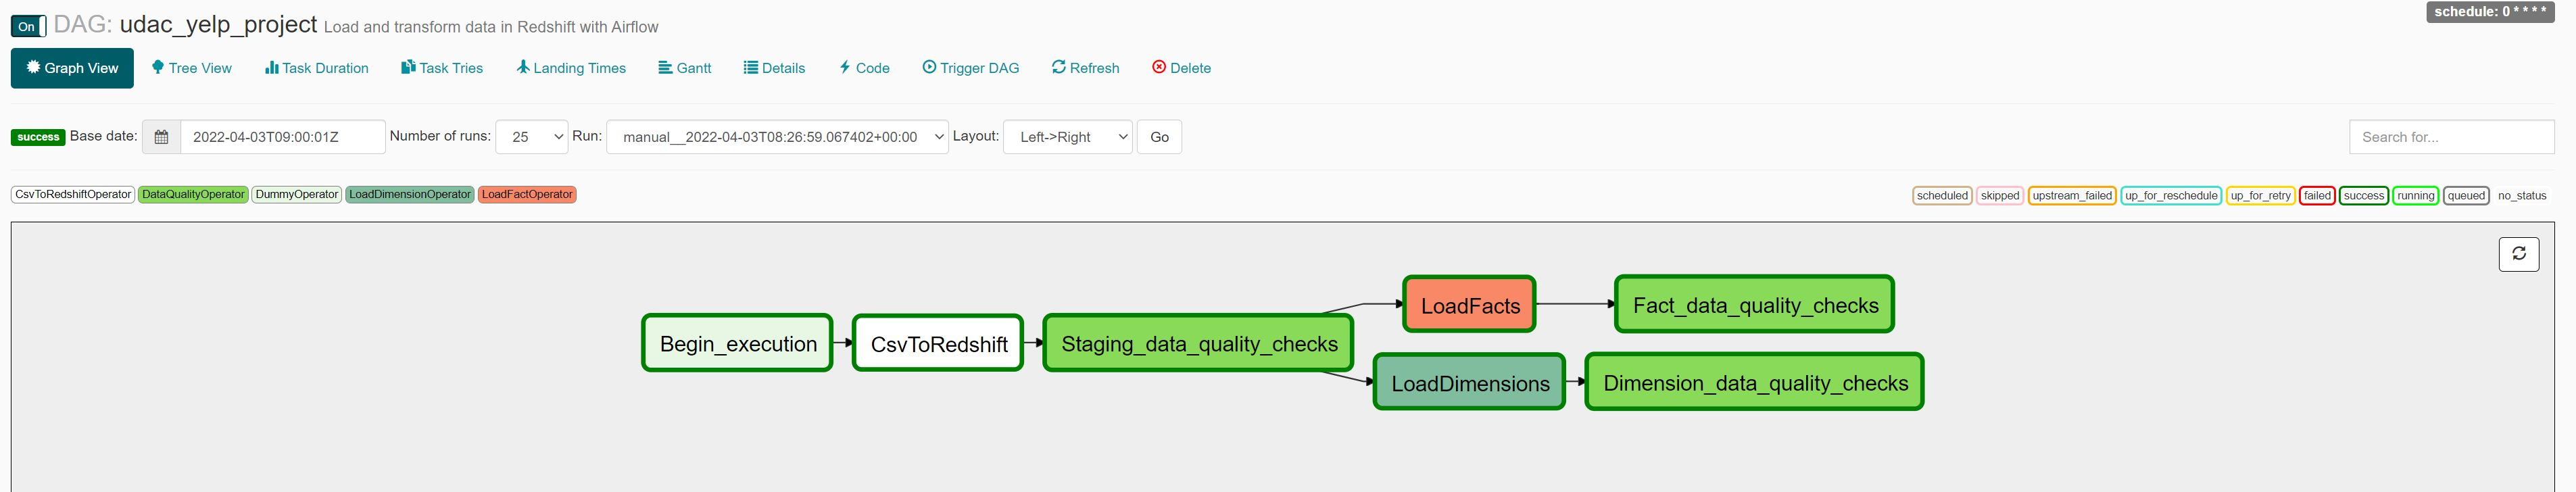

After the process, the data dictionary is as follows: 

**public.fact_review**
- review_id -- unique review id. This id is automatically generated when a new review is left. 
- user_id -- unique user id. This id is automatically generated when a new user is created. 
- business_id -- unique business id. This id is automatically generated when a new business is registered. 
- review_ts -- timestamp when the review is left
- review_date -- date when the review is left
- stars -- how the user rate the business
- useful -- how does the other users' rating towards this comment i.e is it useful or not 
- funny -- how does the other users' rating towards this comment i.e is it funny or not 
- cool -- how does the other users' rating towards this comment i.e is it cool or not

**public.fact_checkin**
- business_id -- unique business id. This id is automatically generated when a new business is registered. 
- checkin_ts -- timestamp when the checkin is made
- checkin_date -- date when the checkin is made
- year -- year when the checkin is made
- month -- month when the checkin is made
- day -- day number when the checkin is made
- hour -- hour when the checkin is made
- minute -- minute when the checkin is made

**public.fact_tip**
- user_id -- unique user id. This id is automatically generated when a new user is created.
- business_id -- unique business id. This id is automatically generated when a new business is registered.
- tip_ts -- timestamp when the a tip/complement is left
- tip_date -- date when the a tip/complement is left
- tip_year -- year when the a tip/complement is left
- tip_month -- month when the a tip/complement is left
- tip_hour -- hour when the a tip/complement is left
- tip_minute -- minute when the a tip/complement is left
- compliment_count -- Is the tip a compliment or not

**public.dim_business**
- business_id -- unique business id. This id is automatically generated when a new business is registered.
- name -- business name 
- address -- business address
- stars -- stars received 
- review_count -- how many reviews are left 
- is_open -- if the business is still opening or closed
- categories -- business categories 
- location_id -- the unique combination of city, state and postal code

**public.dim_cities**
- city -- city name
- state -- state name 
- state_code -- state code 
- avg_household_size -- the average family size 
- median_age -- the age median  
- male_population -- total population of males
- female_population -- total population of females
- total_population -- total no.of inhabitants

**public.dim_business_location**
- location_id -- the unique combination of city, state and postal code
- city -- city name 
- state -- state name 
- postal_code -- postal code

**public.dim_users**
- user_id -- unique user id. This id is automatically generated when a new user is created.
- name -- user name 
- yelping_since_ts -- timestamp when the user was registered
- yelping_since_date -- date when the user was registered
- review_count -- how many review did the user leave
- useful -- how many users vote this user's comment userful
- funny -- how many users vote this user's comment funny
- cool -- how many users vote this user's comment cool
- fan -- how many fans did this user have
- average_stars -- the general rating that this user gives 

## Step 5: Complete Project Write Up

**Situation 1: The data was increased by 100x.**
- For the data cleaning process, we will need to set up EMR cluster in AWS, and to load spark there to process the data. 
- For ETL process, it would not be affected as it is scalable in redshift

**Situation 2: The pipelines would be run on a daily basis by 7 am every day**
- This would be easy as we can set the schedule in airflow and run it at 7pm every day

**The database needed to be accessed by 100+ people.**
- There would be no problem as the AWS redshift is scalable